<h1><center>
<img align="middle" style="display: inline;" src="figs/cds_log.png" alt="logo" width="250px" hspace="20"/>
<img align="middle" style="display: inline;" src="figs/inria_logo.png" alt="logo" width="100px" hspace="20"/>
<img align="middle" style="display: inline;" src="figs/usc_logo.png" alt="logo" width="150px"/>
<img align="middle" style="display: inline;" src="figs/aws_powered_by_logo.jpeg" alt="logo" width="100px"/>
</center>
</h1>

<font color='red'>TODO: add better quality logos, add relative link to github </font> 


<div style="text-align: center">
<img src="figs/stroke_logo.png" width="350px" />
</div>

# <center> RAMP: segmentation of the brain lesions </center>

<br>
<div style="text-align: left">
    <em>
        <i><b>Authors: </b>Maria Teleńczuk, Swetha Shankar, Lucy Liu, Guillaume Lemaitre, Alexandre Gramfort</i>
        <a href="http://www.datascience-paris-saclay.fr">Paris-Saclay Center for Data Science</a> (Inria), France<br>
    </em>
    <em>  
        <i>Sook-Lei Liew</i>
        <a href="https://chan.usc.edu/npnl/">Neural Plasticity & Neurorehabilitation Lab</a> (USC), USA<br>
        </em>
        
</div>

# Table of contents
1. [Introduction](#Introduction)
3. [Submission](#Submission) 

# Introduction <a class="anchor" id="Introduction"></a>

Stroke is the leading cause of adult disability worldwide, with up to two-thirds of individuals experiencing long-term disabilities. Large-scale neuroimaging studies have shown promise in identifying robust biomarkers (e.g., measures of brain structure) of stroke recovery. However, analyzing large datasets is problematic due to barriers in accurate stroke lesion segmentation. Manually-traced lesions are currently the gold standard for lesion segmentation, but are labor intensive and require anatomical expertise. While algorithms have been developed to automate this process, the results often lack accuracy. Newer algorithms that employ machine-learning techniques are promising, yet these require large training datasets to optimize performance. Recently, larger datasets have been made available, sparking renewed efforts to improve automated lesion segmentation algorithms. <br>

More information:
<a href="http://fcon_1000.projects.nitrc.org/indi/retro/atlas.html">Anatomical Tracings of Lesions After Stroke</a>

## References

<a href="https://www.sciencedirect.com/science/article/abs/pii/S1361841516301268">1. Maier, Oskar, et al. "ISLES 2015-A public evaluation benchmark for ischemic stroke lesion segmentation from multispectral MRI." Medical image analysis 35 (2017): 250-269.</a><br>

<a href="https://www.nature.com/articles/sdata201811">2. Liew, Sook-Lei, et al. "A large, open source dataset of stroke anatomical brain images and manual lesion segmentations." Scientific data 5 (2018): 180011.</a><br>


In this challenge you will be given 3D medical images (T1 MRI scans) of the stroke patients and the files with the corresponding lesions (binary masks) traced by hand by experts. Your algorithm will be scored on the timing and the precision. Before we look closer at the data, let's import all the necessary libraries (feel free to skip it if you have done it already):

# Imports

### Prerequisites

- Python >= 3.7
- [nilearn](https://nilearn.github.io/)
- [numpy](https://pypi.org/project/numpy/)
- [osfclient](https://github.com/osfclient/osfclient)  # used for downloading the data
- [scipy](https://pypi.org/project/scipy/)
- [pandas](https://pypi.org/project/pandas/)
- [scikit-learn](https://pypi.org/project/scikit-learn/)
- [matplolib](https://pypi.org/project/matplotlib/)
- [jupyter](https://pypi.org/project/jupyter/)
- [ramp-workflow](https://pypi.org/project/ramp-workflow/)
- [ramp-utils](https://github.com/paris-saclay-cds/ramp-board/)

The following cell will install the required pacakge dependencies, if necessary.

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install ramp-workflow
!{sys.executable} -m pip install ramp-utils

To get this notebook running and test your models locally using `ramp-test` (from ramp-workflow), we recommend that you use the Anaconda or Miniconda Python distribution.

# Data exploration

## Download the data (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

<font color='red'>Note: Please be patient, the data is large. </font> 

In [2]:
# !python download_data.py

You should now be able to find the test and train folders in the data/ directory

## Viewing the data files

In your `data` folder you should now be able to find the directories with names: `subject_1`, `subject_2` and so on. Inside each of them you will find two files: `T1.nii.gz` and `truth.nii.gz`:
 - `T1.nii.gz` is a file with a 3D T1 (MRI) brain scan of the patient
 - `truth.nii.gz` is a file with the binary mask of the same size as T1 image. 0 corresponds to no lesion, 1 corresponds to the lesion. The true lesions were traced by the experts by hand

If you wish to view any of those files from outside of Python, there are many applications available online. For example you might want to use [ITK-snap](http://www.itksnap.org/pmwiki/pmwiki.php). There, you can load the `T1.nii.gz` as a Main Image and `truth.nii.gz` as a Segmentation to overlap the two. Here, we won't go into the details of how to use ITK-snap.

To load the images to Python, we will be using [Nilearn](https://nilearn.github.io/) Python library, but there are other possible options so feel free to choose your favorite one (if, for your submission, you will want to use a libarary which is not included within the `environment.yml` feel free to contact us and, if reasonable, we will add it to the RAMP environment).

## View data

[MRI](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging#:~:text=Magnetic%20resonance%20imaging%20(MRI)%20is%20the%20organs%20in%20the%20body.) is short for the magnetic resonance imaging. MRI images consist of scans of the brain at different depths and then combined together to form the 3d image of the brain. 

Let's view few some of the images:

In [3]:
path_T1_1 = 'data/train/subject_2/T1.nii.gz'
path_T1_2 = 'data/train/subject_8/T1.nii.gz'
path_T1_3 = 'data/train/subject_18/T1.nii.gz'

path_lesion_1 = 'data/train/subject_2/truth.nii.gz'
path_lesion_2 = 'data/train/subject_8/truth.nii.gz'
path_lesion_3 = 'data/train/subject_18/truth.nii.gz'

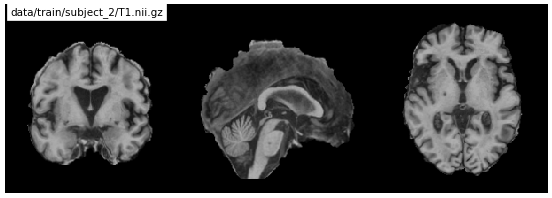

In [4]:
%matplotlib inline

from nilearn import plotting
import os
import matplotlib.pylab as plt

def plot_t1(path_to_t1, title='T1'):
    fig = plt.figure(1, figsize=(14, 5), frameon=False, dpi=50)
    ax = plt.gca()
    plotting.plot_anat(path_to_t1, title=title,
                       axes=ax,
                       draw_cross=False,
                       annotate=False,
                       cut_coords=(0, 0, 0)
                       )
plot_t1(path_to_t1=path_T1_1, title=f'{path_T1_1}')
# TODO: choose the images with 1) no visible lesion; 2) small lesion; 3) large lesion

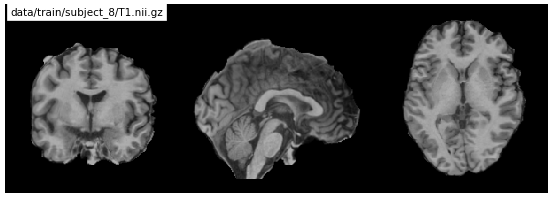

In [5]:
plot_t1(path_to_t1=path_T1_2, title=f'{path_T1_2}')

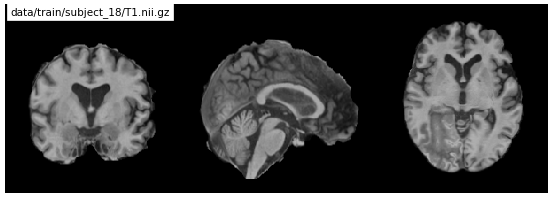

In [6]:
plot_t1(path_to_t1=path_T1_3, title=f'{path_T1_3}')

We plotted the T1 image for three different patients shown at three different axes. Some preprocessing has been done to them already. Here are the steps which were performed:

1. First as described [here](https://www.nature.com/articles/sdata201811) TODO: go into the details
2. And in addition:
    - skull was removed
    - bias was corrected
    - images were aligned to MNI space

Can you already make some guesses on where the lesions are located?

Before we look closer at the lesions, let's look at the size of the images

In [7]:
from nilearn.image import load_img
    
img1 = load_img(path_T1_1)
img2 = load_img(path_T1_2)
img3 = load_img(path_T1_3)

print(f"Shape of the first T1 scan is: {img1.shape}, of the second: {img2.shape}, of the third: {img3.shape}")

Shape of the first T1 scan is: (193, 229, 193), of the second: (193, 229, 193), of the third: (193, 229, 193)


Here we checked the sizes of only three of the scans, but if you look at the others you will notice that they all have the same size. This is because one of our preprocessing steps was to normalize all of the data to MNI space. 

Every brain is different and it would have been difficult to compare them if we took them straight as recorded by the MRI scanner. Now, look closer at the images which we plotted above: even though the preprocessing has been done you can still notice differences between the brains which are visible to the naked eye.

So what is an MNI brain? It is a template brain made from careful averaging of many brain scans. You can find out more about it [here](http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009). 

By normalizing to the MNI space we are trying to align and warp the brain to match the template brain. This also leads to normalization of the size of the image, hece the same shape of all the scans we have here.

## Lesion analysis

Now, that we understand better the anatomical T1 images that we will work with, let's look at the lesion masks. Although it is easiest to scroll through the 3D brain image to find the lesion and see the lesion overlay (which can be done in ITK Snap or other software), we can quickly visualize overlap of the two in 2D planes like so:

In [8]:
from nilearn.image import load_img

/home/maja/anaconda3/envs/stroke/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


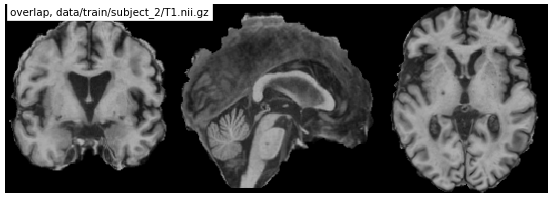

In [9]:
def plot_overlap(path_to_t1, path_to_lesion, title='overlap'):
    fig = plt.figure(1, figsize=(14, 5), frameon=False, dpi=50)
    ax = plt.gca()
    plotting.plot_roi(path_to_lesion, path_to_t1, title=title,
                       axes=ax,
                       draw_cross=False,
                       annotate=False, 
                       cmap='autumn',  # the lesions will be shown in red
                       cut_coords=(0, 0, 0)
                       )
plot_overlap(path_to_t1=path_T1_1,
             path_to_lesion=path_lesion_1,
             title=f'overlap, {path_T1_1}')

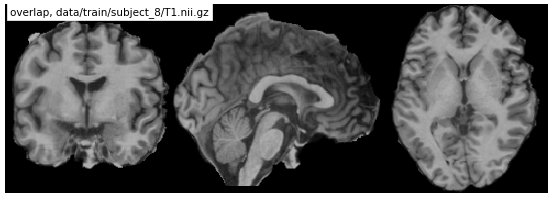

In [10]:
plot_overlap(path_to_t1=path_T1_2,
             path_to_lesion=path_lesion_2,
             title=f'overlap, {path_T1_2}')

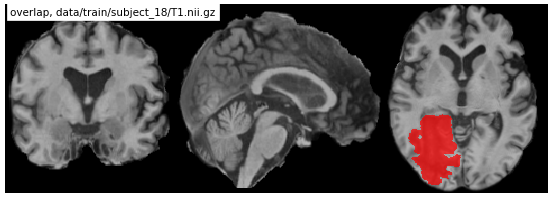

In [11]:
plot_overlap(path_to_t1=path_T1_3,
             path_to_lesion=path_lesion_3,
             title=f'overlap, {path_T1_3}')

Did you guess correctly the locations of the lesions? What else did you notice?

Probably the most noticable thing is that the lesions are not of the same size nor they are in the same location. In one of the subjects, the lesion is not even in the plane that we are looking at, or is it there at all?

Feel free to also look at the data of other subjects. You can view different planes by changing `cut_coords` parameter.

Lets now look at the voxel sizes of the lesions of some patients (here we will consider only 10 of them):

In [12]:
import numpy as np

data_dir = 'data/train'  # path to your data directory
data_dirs = os.listdir(data_dir)

for subject_dir in data_dirs[:10]:
    path_mask = os.path.join(data_dir,
                             subject_dir,
                             'truth.nii.gz')
    mask = load_img(path_mask)
    mask_data = mask.get_fdata()
    mask_size = int(np.sum(mask_data))
    print(f"mask voxel size: {mask_size} for {subject_dir}")
    
    
    del mask, mask_data

mask voxel size: 20585 for subject_90
mask voxel size: 6490 for subject_4
mask voxel size: 825 for subject_20
mask voxel size: 95948 for subject_36
mask voxel size: 32904 for subject_85
mask voxel size: 447 for subject_42
mask voxel size: 1259 for subject_84
mask voxel size: 78 for subject_22
mask voxel size: 363 for subject_16
mask voxel size: 25 for subject_45


The sizes of the lesions vary a lot between patients.

<font color='red'>Note: All the masks include at least a small lesion. </font> 

# Sample prediction algorithms

To get familiar with the way we expect you to submit your algorithm we will now go through some sample solutions. 

## Dummy solution (predict only 1s)

In the path of this challenge you can find a directory called `submissions/sample`. If you want to test your solution locally you will need to place your submission directory in the `submissions` folder, eg `submissions/my_submission`. There, you will have a single python file called `estimator.py`. Let's look at the `submissions/sample/estimator.py`:

In [13]:
# %load submissions/sample/estimator.py
from nilearn.image import load_img
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import ClassifierMixin
from sklearn.pipeline import Pipeline


class Dummy(BaseEstimator, ClassifierMixin, TransformerMixin):
    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        # returns y filled with only 1s

        x_path = X[0]
        x_data = load_img(x_path)
        x_shape = x_data.shape
        y = np.ones((len(X), x_shape[0], x_shape[1], x_shape[2]))

        return y


def get_estimator():

    # sets all the masks to all 1s
    dummy = Dummy()

    pipeline = Pipeline([
        ('classifier', dummy)
    ])

    return pipeline


You can test this or any other submission with the command (in your terminal):

`ramp-test --submission <your submission folder name> --quick-test`

`--quick-test` tells RAMP to use only 5 subjects from the dataset. Omit this option if you wish to train on the whole dataset (may be much slower)

RAMP will be searching for the function `get_estimator()` within your `estimator.py` file. This function needs to return [Sklearn type of pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

So how does it work?

RAMP will use functions `get_train_data()` and `get_test_data()` which are found in the `problem.py` file in current challenge directory (you are free to view this file, but you will not be able to submit other version of it). Those functions will return `X` and `y` data. 

`X` is an array which stores the paths to the `T1.nii.gz` (we are not loading them all to the memory as you might find it more efficient to work with each of them separately or with small batches of data). In our Dummy algorithm above we are loading the data using `load_img()` function from `nilearn.image`. 


`y` is an array with four dimensions: `n_samples` x `x_len` x `y_len` x `z_len` where `x_len`, `y_len` and `z_len` are dimensions of the MRI scans. In the Dummy algorithm we are not using `y` for trainining (ie in `fit()`), however test `y` data is compared to your solution and used to score the output.

Let's go step by step through what happens:

Load the train dataset (we will load only data for 5 subjects):

In [14]:
dir_data_train = 'data/train'
list_subj_dirs_train = os.listdir(dir_data_train)

def get_data(dir_data, list_subj_dirs):
    # we will use only 5 subjects here
    list_subj_dirs = list_subj_dirs[:5]

    n_samples = len(list_subj_dirs)
    # we will be loading only the directory paths
    X = np.empty(n_samples, dtype='<U128')
    # we will be loading all the lesions arrays in


    for idx, next_subj in enumerate(list_subj_dirs):
        X[idx] = os.path.join(dir_data, next_subj, 'T1.nii.gz')
        y_path = os.path.join(dir_data, next_subj, 'truth.nii.gz')
        if idx == 0:
            # check the shape of the data (we assume all the scans
            # have the same shape)
            y = load_img(y_path).get_fdata()
            _x_len, _y_len, _z_len = np.shape(y)
            y = np.empty((n_samples, _x_len, _y_len, _z_len))
        y[idx, :] = load_img(y_path).get_fdata()
    return X, y
X_train, y_train = get_data(dir_data_train, list_subj_dirs_train)

In [15]:
print(f'X_train is a {type(X_train)} with {len(X_train)} elements: \n{X_train}\n')
print(f'y_train is a {type(y_train)} of shape: {y_train.shape}.')
print(f'Its unique elements include {np.unique(y_train)}')

X_train is a <class 'numpy.ndarray'> with 5 elements: 
['data/train/subject_90/T1.nii.gz' 'data/train/subject_4/T1.nii.gz'
 'data/train/subject_20/T1.nii.gz' 'data/train/subject_36/T1.nii.gz'
 'data/train/subject_85/T1.nii.gz']

y_train is a <class 'numpy.ndarray'> of shape: (5, 193, 229, 193).
Its unique elements include [0. 1.]


Although, RAMP will use cross validation to train and test your data we will not showcase it here. However note that when testing your algorithm locally you will see a score for each of your cross validation steps and the combined score in the end.

Here we will directly fit the algorithm of all our loaded train data:

In [16]:
dummy_pipe = get_estimator()
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('classifier', Dummy())])

Now we will load the test dataset:

In [17]:
dir_data_test = 'data/test'
list_subj_dirs_test = os.listdir(dir_data_test)

X_test, y_test = get_data(dir_data_test, list_subj_dirs_test)

In [18]:
print(f'X_test is a {type(X_test)} with {len(X_test)} elements: \n{X_test}\n')
print(f'y_test is a {type(y_test)} of shape: {y_test.shape}.')
print(f'Its unique elements include {np.unique(y_test)}')

X_test is a <class 'numpy.ndarray'> with 5 elements: 
['data/test/subject_228/T1.nii.gz' 'data/test/subject_215/T1.nii.gz'
 'data/test/subject_212/T1.nii.gz' 'data/test/subject_218/T1.nii.gz'
 'data/test/subject_202/T1.nii.gz']

y_test is a <class 'numpy.ndarray'> of shape: (5, 193, 229, 193).
Its unique elements include [0. 1.]


Now we will get predicted `y`:

In [19]:
y_pred = dummy_pipe.predict_proba(X_test)

In [20]:
print(f'y_pred is a {type(y_pred)} of shape: {y_pred.shape}.')
print(f'Its unique elements include {np.unique(y_pred)}')

y_pred is a <class 'numpy.ndarray'> of shape: (5, 193, 229, 193).
Its unique elements include [1.]


It is what we expected. `y_pred` is of the same shape as `y_test` and it includes only 1s.

What RAMP is doing next is scoring the predictions. The score which RAMP is using for this challenge is defined in the `problem.py` file: 

## Scores used
- Dice’s coefficient (DC): describes the volume overlap between two segmentations and is sensitive to the lesion size;
- <font color='red'>TODO: add more score</font> 

In [21]:
from problem import DiceCoeff

dice_coeff = DiceCoeff()
score = dice_coeff(y_test, y_pred)
print(f'Score for Dummy algorithm is {np.round(score, 4)}')

Score for Dummy algorithm is 0.0036


This is the score which you should get when testing locally using

`ramp-test --submission <your submission folder name> --quick-test`

If you submit the Dummy solution on RAMP the score might vary slightly because for testing your algorithm RAMP will use different dataset 

## A (slightly) more complex algorithm

In the today's world when one think of image segmentation s/he instantly associates it with deep learning algorithms. We do support deep learning solutions. Each of the algorithms submitted to this challenge will be trained on the AWS machines kindly sponsored by Amazon 
<img align="middle" style="display: inline;" src="figs/aws_logo2.png" alt="logo" width="100px"/>

<font color='red'>Note that there is a limit allocated to each participant:</font>
<font color='red'>
1. TODO: add max number of submissions
2. TODO: hours of GPU time per submission allocated to each participant
3. TODO: frequency of allowed submissions
</font>

However, a good way to explore and better understand the data is to first try some more traditional machine learning algorithms. For instance we can consider different features of each of the pixel. In the solution we will use functions from [Scikit-Learn](https://scikit-learn.org/stable/) and [Scikit-Image](https://scikit-image.org/) Python libraries.
This solution is partly taken from [here](https://eoss-image-processing.github.io/2020/06/24/trainable-segmentation.html).

## TODO: (hidden) script for making a movie + show the movie

## read the masks + show the difference in the mask sizes

sample example script: average the brains or use template to subtracted and see if we get the lesion

## 2. Scikit image image segmentation example??

## deep learning possible ideas

In [22]:
## here we adapted the unet algorithm, explain unet, references etc

Training the model with fit (in the starting kit example, we load some pretrained weights to be able to show results here, but note this is not possible for an actual submission):

    predict few of the images

show the score

In [23]:
Explain how to make the submission

SyntaxError: invalid syntax (<ipython-input-23-0b8750893509>, line 1)

explain potential possiblity to use AWS services/ limits

## Submission <a class="anchor" id="Submission"></a> 

Once you found a good model you wish to test you should place it in a directory, naming it as you wish, and place it in the `submissions/` folder (you can already find there two submissions in the folders `submissions/starting_kit` and `submissions/lasso_lars` which we talked about above). The file placed in your submission directory (e.g., `starting_kit/` should be called `estimator.py` and should define a function called `get_estimator` that returns a scikit-learn type of pipeline.

You can then test your submission locally using the command:

`ramp-test --submission <your submission folder name>`

if you prefer to run a quick test on much smaller subset of data you can add `--quick-test` option:

`ramp-test --submission <your submission folder name> --quick-test`


For more information on how to submit your code on [ramp.studio](https://ramp.studio/), refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).